### Part 1 Data preparation and visualization

1. Read the dataset 
2. Delete all the rows containing the missing data. Imputation is not necessary. 
3. Encode the data where necessary. 
4. Visualize the columns and their pairs. 
5. Produce the correlation matrix to make a first guess on usefulness of the predictors.

In [2]:
data = pd.read_csv('dealer_data.csv'), usecols=['sex','age','income','purchase'])
data.head()

,sex,age,income,purchase
0,Male,19.0,19000.0,0.0
1,Male,35.0,20000.0,0.0
2,Female,26.0,43000.0,0.0
3,Female,27.0,57000.0,0.0
4,Male,19.0,76000.0,0.0


In [3]:
data.shape

(502, 4)

In [4]:
data['sex'].value_counts()

Female    257
Male      245
Name: sex, dtype: int64

In [5]:
data[['age', 'income','purchase']].describe()

,age,income,purchase
count,481.000000,476.000000,482.000000
mean,39.022869,69399.159664,0.394191
std,10.476437,33758.029366,0.489184
min,18.000000,15000.000000,0.000000
25%,31.000000,43000.000000,0.000000
50%,39.000000,69500.000000,0.000000
75%,47.000000,87000.000000,1.000000
max,60.000000,150000.000000,1.000000


In [6]:
for col in data.columns:

    missing_vals = data[data[col].isna()].shape[0]
    
    print("column", col, "has", missing_vals, "missing values")

column sex has 0 missing values
column age has 21 missing values
column income has 26 missing values
column purchase has 20 missing values


In [7]:
clean_data = data.dropna()

In [8]:
for col in clean_data.columns:

    missing_vals = clean_data[clean_data[col].isna()].shape[0]
    
    print("column", col, "has", missing_vals, "missing values")

column sex has 0 missing values
column age has 0 missing values
column income has 0 missing values
column purchase has 0 missing values


In [9]:
clean_data['sex'] = pd.get_dummies(clean_data['sex'], drop_first=True)

In [10]:
clean_data.corr()

,sex,age,income,purchase
sex,1.000000,-0.076477,-0.027163,-0.030211
age,-0.076477,1.000000,0.127944,0.632383
income,-0.027163,0.127944,1.000000,0.336978
purchase,-0.030211,0.632383,0.336978,1.000000


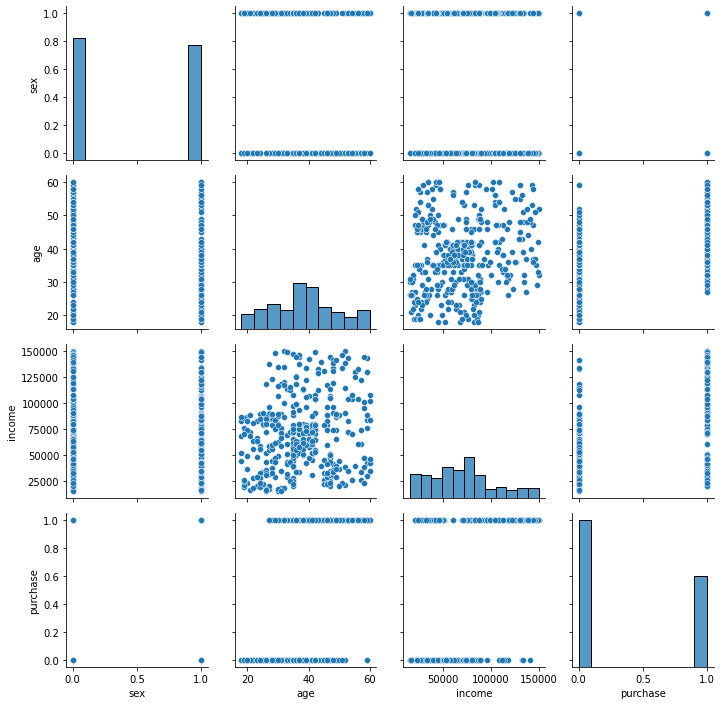

In [11]:
import seaborn as sns

g = sns.PairGrid(clean_data)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

### Part 2 Inference by logistic regression

1. You have 3 predictors (sex, age, income) and the target class variable purchase, taking the value 1 if he or she already bought a car once in the past. To predict this class for new potential customers, you need to learn the logistic regression model parameters. 
2. Divide your client base into training and testing sets. 
3. Fit the model on a training set. 
4. Produce your estimated regression equation, interpret the coefficients and comment on the regression summary. 
5. Try to reduce your model, dropping some predictors, and repeat the above steps with each reduced version. 
6. Compare the fitting results for your models.

In [12]:
from sklearn.model_selection import train_test_split

X = clean_data.drop(['purchase'], axis=1)
y = clean_data['purchase']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=2)

In [13]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=2, solver='newton-cg')
lr.fit(X_train, y_train)
coefs = lr.coef_
intercept = lr.intercept_

In [14]:
sample = X_test.sample()
sample

,sex,age,income
243,0,56.0,104000.0


In [15]:
def regression_equation(features, coefs, intercept):
    
    z = intercept + np.dot(coefs, features.transpose())
    
    result = 1 / (1 + np.exp(-z))
    
    return 1-result, result

In [16]:
res = regression_equation(sample, coefs, intercept)
res

(array([[0.00848605]]), array([[0.99151395]]))

In [17]:
lr.predict_proba(sample)

array([[0.00848605, 0.99151395]])

In [18]:
import itertools

features = ['sex', 'income', 'age']
feature_combinations = []

for i in range(1,len(features)+1):
   feature_combinations.extend(list(itertools.combinations(features,i)))

feature_combinations

[('sex',),
 ('income',),
 ('age',),
 ('sex', 'income'),
 ('sex', 'age'),
 ('income', 'age'),
 ('sex', 'income', 'age')]

In [19]:
results = pd.DataFrame(columns=['model', 'features', 'coefficients', 'intercept'])

for features in feature_combinations:
    
    lr = LogisticRegression(random_state=2, solver='newton-cg', penalty='none')
    lr.fit(X_train[list(features)], y_train)
    coefs = lr.coef_
    intercept = lr.intercept_
    
    res = {'model': lr, 'features':features, 'coefficients':coefs, 'intercept': intercept}
    
    results = results.append(res, ignore_index=True)
    
    

In [20]:
results

,model,features,coefficients,intercept
0,"LogisticRegression(penalty='none', random_stat...","(sex,)",[[-0.2395538807132843]],[-0.42488319395531116]
1,"LogisticRegression(penalty='none', random_stat...","(income,)",[[2.4721668973126758e-05]],[-2.319473712621525]
2,"LogisticRegression(penalty='none', random_stat...","(age,)",[[0.1901922610634426]],[-8.177552025957855]
3,"LogisticRegression(penalty='none', random_stat...","(sex, income)","[[-0.29206998915812926, 2.4871767936355425e-05]]",[-2.1922788785308858]
4,"LogisticRegression(penalty='none', random_stat...","(sex, age)","[[0.1915701425977996, 0.19195541879958816]]",[-8.340654318569134]
5,"LogisticRegression(penalty='none', random_stat...","(income, age)","[[4.246128056491223e-05, 0.254053576207142]]",[-13.823922576723499]
6,"LogisticRegression(penalty='none', random_stat...","(sex, income, age)","[[0.2125275480142318, 4.240793739671124e-05, 0...",[-14.025979469279537]


### Part 3. Prediction

1. For each of the fitted models, predict the purchase class for the training set. 
2. For each of the fitted models, predict the purchase class for the testing set.

In [21]:
predictions = pd.DataFrame(columns=['train', 'test'])

for i in results.index:
    pred_train = results['model'][i].predict(X_train[list(results['features'][i])])
    pred_test = results['model'][i].predict(X_test[list(results['features'][i])])
    
    result = {'train': pred_train, 'test':pred_test}
    
    predictions = predictions.append(result, ignore_index=True)
    
results = pd.concat([results,predictions],axis=1)
results

,model,features,coefficients,intercept,train,test
0,"LogisticRegression(penalty='none', random_stat...","(sex,)",[[-0.2395538807132843]],[-0.42488319395531116],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"LogisticRegression(penalty='none', random_stat...","(income,)",[[2.4721668973126758e-05]],[-2.319473712621525],"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,"LogisticRegression(penalty='none', random_stat...","(age,)",[[0.1901922610634426]],[-8.177552025957855],"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ..."
3,"LogisticRegression(penalty='none', random_stat...","(sex, income)","[[-0.29206998915812926, 2.4871767936355425e-05]]",[-2.1922788785308858],"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,"LogisticRegression(penalty='none', random_stat...","(sex, age)","[[0.1915701425977996, 0.19195541879958816]]",[-8.340654318569134],"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ..."
5,"LogisticRegression(penalty='none', random_stat...","(income, age)","[[4.246128056491223e-05, 0.254053576207142]]",[-13.823922576723499],"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ..."
6,"LogisticRegression(penalty='none', random_stat...","(sex, income, age)","[[0.2125275480142318, 4.240793739671124e-05, 0...",[-14.025979469279537],"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ..."


### Part 4. Evaluation of the prediction quality

1. Produce the confusion matrix and the classification report for each of the predictions. 
2. Compare the results between the different models and also training versus testing sets.

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score

In [23]:
metrics = pd.DataFrame(columns=['train - confusion matrix', 'train - accuracy', 'train - precision', 'train - recall','train - f-score',
                               'test - confusion matrix', 'test - accuracy', 'test - precision', 'test - recall','test - f-score'])

for i in results.index:
    
    conf_train = confusion_matrix(y_train, results['train'][i])
    acc_train = accuracy_score(y_train, results['train'][i])
    prec_train = precision_score(y_train, results['train'][i])
    recall_train = recall_score(y_train, results['train'][i])
    f1_train = f1_score(y_train, results['train'][i])
    
    conf_test = confusion_matrix(y_test, results['test'][i])
    acc_test = accuracy_score(y_test, results['test'][i])
    prec_test = precision_score(y_test, results['test'][i])
    recall_test = recall_score(y_test, results['test'][i])
    f1_test = f1_score(y_test, results['test'][i])
    
    result = {'train - confusion matrix':conf_train, 
              'train - accuracy':acc_train, 
              'train - precision':prec_train, 
              'train - recall':recall_train,
              'train - f-score':f1_train,
              'test - confusion matrix':conf_test,
              'test - accuracy':acc_test,
              'test - precision':prec_test,
              'test - recall':recall_test,
              'test - f-score':f1_test}
    
    metrics = metrics.append(result, ignore_index = True)

results = pd.concat([results, metrics], axis=1)

In [24]:
results

,model,features,coefficients,intercept,train,test,train - confusion matrix,train - accuracy,train - precision,train - recall,train - f-score,test - confusion matrix,test - accuracy,test - precision,test - recall,test - f-score
0,"LogisticRegression(penalty='none', random_stat...","(sex,)",[[-0.2395538807132843]],[-0.42488319395531116],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[207, 0], [121, 0]]",0.631098,0.000000,0.000000,0.000000,"[[64, 0], [46, 0]]",0.581818,0.000000,0.000000,0.000000
1,"LogisticRegression(penalty='none', random_stat...","(income,)",[[2.4721668973126758e-05]],[-2.319473712621525],"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[[198, 9], [65, 56]]",0.774390,0.861538,0.462810,0.602151,"[[61, 3], [26, 20]]",0.736364,0.869565,0.434783,0.579710
2,"LogisticRegression(penalty='none', random_stat...","(age,)",[[0.1901922610634426]],[-8.177552025957855],"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...","[[192, 15], [36, 85]]",0.844512,0.850000,0.702479,0.769231,"[[60, 4], [16, 30]]",0.818182,0.882353,0.652174,0.750000
3,"LogisticRegression(penalty='none', random_stat...","(sex, income)","[[-0.29206998915812926, 2.4871767936355425e-05]]",[-2.1922788785308858],"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[[196, 11], [65, 56]]",0.768293,0.835821,0.462810,0.595745,"[[61, 3], [25, 21]]",0.745455,0.875000,0.456522,0.600000
4,"LogisticRegression(penalty='none', random_stat...","(sex, age)","[[0.1915701425977996, 0.19195541879958816]]",[-8.340654318569134],"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...","[[192, 15], [37, 84]]",0.841463,0.848485,0.694215,0.763636,"[[61, 3], [16, 30]]",0.827273,0.909091,0.652174,0.759494
5,"LogisticRegression(penalty='none', random_stat...","(income, age)","[[4.246128056491223e-05, 0.254053576207142]]",[-13.823922576723499],"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...","[[191, 16], [33, 88]]",0.850610,0.846154,0.727273,0.782222,"[[59, 5], [13, 33]]",0.836364,0.868421,0.717391,0.785714
6,"LogisticRegression(penalty='none', random_stat...","(sex, income, age)","[[0.2125275480142318, 4.240793739671124e-05, 0...",[-14.025979469279537],"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...","[[190, 17], [32, 89]]",0.850610,0.839623,0.735537,0.784141,"[[59, 5], [14, 32]]",0.827273,0.864865,0.695652,0.771084
